### Extract stock market data for Amazon from YAHOO Finance

In [41]:
import findspark
findspark.init()
import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession

In [42]:
spark = SparkSession.builder \
    .master("local") \
    .appName("StockMarket") \
    .config("spark.executor.memory", "6gb") \
    .getOrCreate()

In [43]:
df =spark.read.format('com.databricks.spark.csv')\
   .options(header='true', inferschema='true')\
   .load('AMZN.csv')

In [44]:
df.show()

+----------+-------+-------+---------+-------+---------+--------+
|      Date|   Open|   High|      Low|  Close|Adj Close|  Volume|
+----------+-------+-------+---------+-------+---------+--------+
|2000-01-03|   81.5|89.5625|79.046875| 89.375|   89.375|16117600|
|2000-01-04| 85.375|   91.5|    81.75|81.9375|  81.9375|17487400|
|2000-01-05|   70.5| 75.125|     68.0|  69.75|    69.75|38457400|
|2000-01-06|71.3125|72.6875|     64.0|65.5625|  65.5625|18752000|
|2000-01-07|   67.0|   70.5|  66.1875|69.5625|  69.5625|10505400|
|2000-01-10|72.5625| 72.625|  65.5625|69.1875|  69.1875|14757900|
|2000-01-11| 66.875|   70.0|     65.0|  66.75|    66.75|10532700|
|2000-01-12| 67.875|   68.0|     63.0|63.5625|  63.5625|10804500|
|2000-01-13|64.9375|67.1875|   63.125|65.9375|  65.9375|10448100|
|2000-01-14|  66.75| 68.625|     64.0|  64.25|    64.25| 6853600|
|2000-01-18|63.4375|65.1875|     63.0| 64.125|   64.125| 5384900|
|2000-01-19| 64.125|   67.5|     63.0|66.8125|  66.8125| 8245500|
|2000-01-2

### Exploring and visualizing stock market data for Amazon

In [45]:
import pyspark.sql.functions as func

In [46]:
df = df.withColumn('date', func.to_date('Date'))

In [47]:
date_breakdown = ['year', 'month', 'day']
for i in enumerate(date_breakdown):
    index = i[0]
    name = i[1]
    df = df.withColumn(name, func.split('date', '-')[index])

In [48]:
df_plot = df.select('year', 'Adj Close').toPandas()

In [49]:
from matplotlib import pyplot as plt


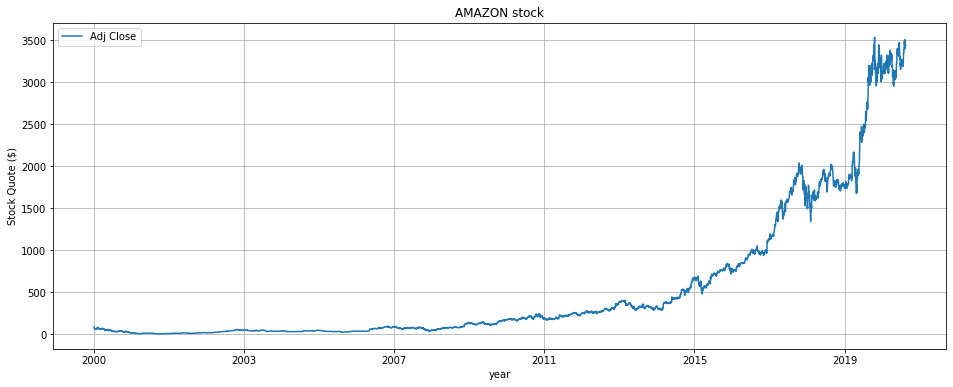

In [50]:
%matplotlib inline

df_plot.set_index('year', inplace=True)
df_plot.plot(figsize=(16, 6), grid=True)
plt.title('AMAZON stock')
plt.ylabel('Stock Quote ($)')
plt.show()

In [51]:
df.toPandas().shape

(5408, 10)

In [52]:
df.dropna().count()

5408

In [53]:
df.select('Open', 'High', 'Low', 'Close', 'Adj Close').describe().show()

+-------+-----------------+-----------------+-----------------+-----------------+-----------------+
|summary|             Open|             High|              Low|            Close|        Adj Close|
+-------+-----------------+-----------------+-----------------+-----------------+-----------------+
|  count|             5408|             5408|             5408|             5408|             5408|
|   mean|535.8981692821749|541.7467842855041|529.3981465336542|535.7620004197496|535.7620004197496|
| stddev|822.9195087113982|831.6190258530577|812.9042526684628|822.3170578510645|822.3170578510645|
|    min|             5.91|              6.1|             5.51|             5.97|             5.97|
|    max|           3547.0|           3554.0|      3486.689941|      3531.449951|      3531.449951|
+-------+-----------------+-----------------+-----------------+-----------------+-----------------+



### Preparing Data for model performance

In [54]:
df.groupBy(['year']).agg({'Adj Close':'count'})\
     .withColumnRenamed('count(Adj Close)', 'Row Count')\
     .orderBy(["year"],ascending=False)\
     .show()

+----+---------+
|year|Row Count|
+----+---------+
|2021|      124|
|2020|      253|
|2019|      252|
|2018|      251|
|2017|      251|
|2016|      252|
|2015|      252|
|2014|      252|
|2013|      252|
|2012|      250|
|2011|      252|
|2010|      252|
|2009|      252|
|2008|      253|
|2007|      251|
|2006|      251|
|2005|      252|
|2004|      252|
|2003|      252|
|2002|      252|
+----+---------+
only showing top 20 rows



In [55]:
trainDF = df[df.year < 2020]
testDF = df[df.year > 2019]

In [56]:
trainDF.toPandas().shape
testDF.toPandas().shape

(377, 10)

In [57]:
trainDF.toPandas().shape

(5031, 10)

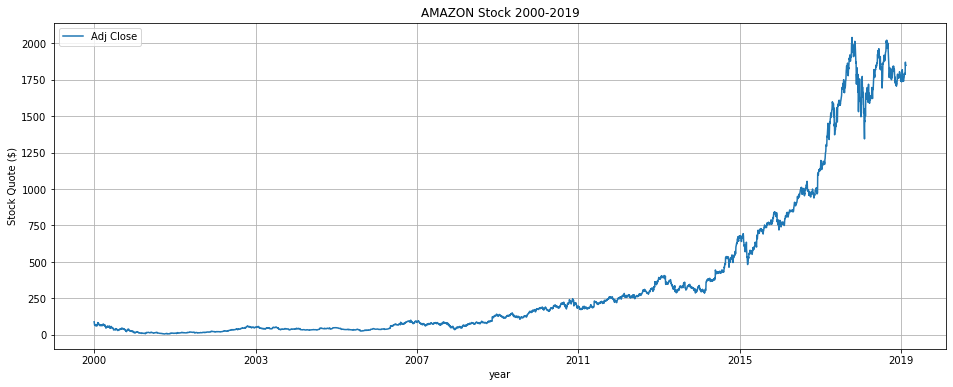

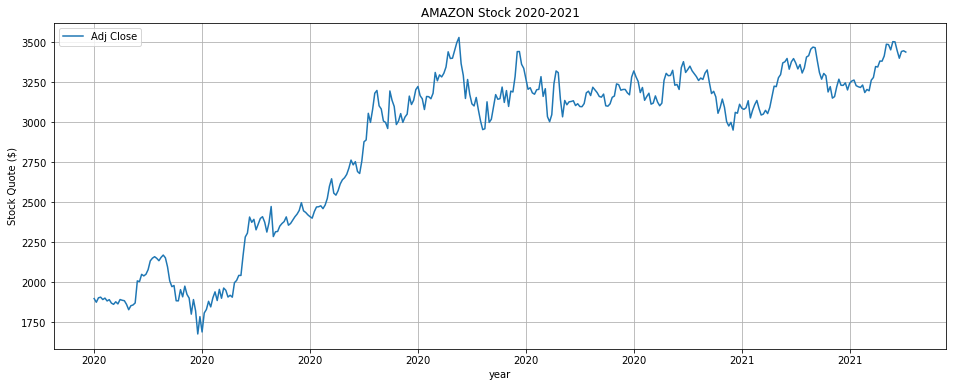

In [58]:
trainDF_plot = trainDF.select('year', 'Adj Close').toPandas()
trainDF_plot.set_index('year', inplace=True)
trainDF_plot.plot(figsize=(16, 6), grid=True)
plt.title('AMAZON Stock 2000-2019')
plt.ylabel('Stock Quote ($)')
plt.show()

testDF_plot = testDF.select('year', 'Adj Close').toPandas()
testDF_plot.set_index('year', inplace=True)
testDF_plot.plot(figsize=(16, 6), grid=True)
plt.title('AMAZON Stock 2020-2021')
plt.ylabel('Stock Quote ($)')
plt.show()

In [59]:
import numpy as np
trainArray = np.array(trainDF.select('Open', 'High', 'Low','Close','Volume','Adj Close').collect())
testArray = np.array(testDF.select('Open', 'High', 'Low', 'Close','Volume','Adj Close').collect())

In [60]:
from sklearn.preprocessing import MinMaxScaler

In [61]:
minMaxScale = MinMaxScaler()

In [62]:
minMaxScale.fit(trainArray)
testingArray = minMaxScale.transform(testArray)
trainingArray = minMaxScale.transform(trainArray)

In [63]:
xtrain = trainingArray[:, 0:-1]
xtest = testingArray[:, 0:-1]
ytrain = trainingArray[:, -1:]
ytest = testingArray[:, -1:]

In [64]:
print('xtrain shape = {}'.format(xtrain.shape))
print('xtest shape = {}'.format(xtest.shape))
print('ytrain shape = {}'.format(ytrain.shape))
print('ytest shape = {}'.format(ytest.shape))

xtrain shape = (5031, 5)
xtest shape = (377, 5)
ytrain shape = (5031, 1)
ytest shape = (377, 1)


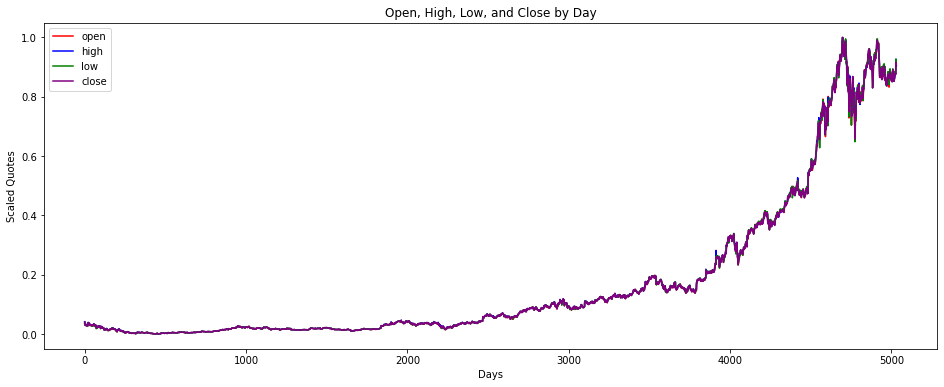

In [65]:
plt.figure(figsize=(16,6))
plt.plot(xtrain[:,0],color='red', label='open')
plt.plot(xtrain[:,1],color='blue', label='high')
plt.plot(xtrain[:,2],color='green', label='low')
plt.plot(xtrain[:,3],color='purple', label='close')
plt.legend(loc = 'upper left')
plt.title('Open, High, Low, and Close by Day')
plt.xlabel('Days')
plt.ylabel('Scaled Quotes')
plt.show()

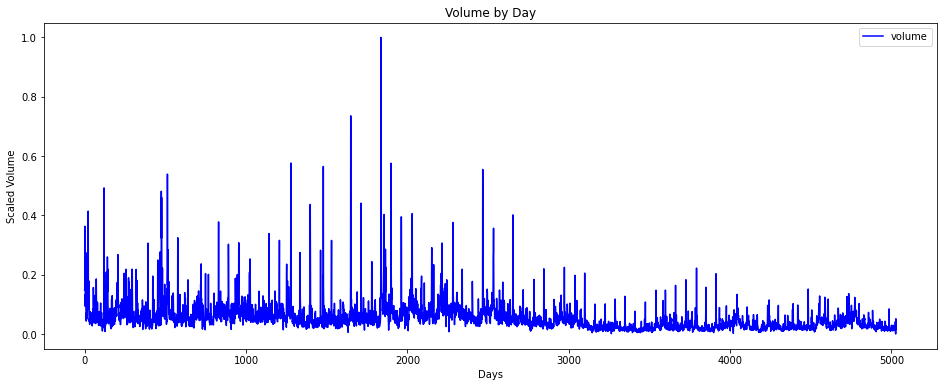

In [66]:
plt.figure(figsize=(16,6))
plt.plot(xtrain[:,4],color='blue', label='volume')
plt.legend(loc = 'upper right')
plt.title('Volume by Day')
plt.xlabel('Days')
plt.ylabel('Scaled Volume')
plt.show()

### Building the LSTM Model

In [67]:
from keras import models, layers

In [68]:
import tensorflow as tf

In [69]:
model = models.Sequential()
model.add(layers.LSTM(1, input_shape=(1,5)))
model.add(layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [70]:
xtrain = xtrain.reshape((xtrain.shape[0], 1, xtrain.shape[1]))
xtest = xtest.reshape((xtest.shape[0], 1, xtest.shape[1]))

In [71]:
loss = model.fit(xtrain, ytrain, batch_size=10, epochs=100)

Epoch 1/100
504/504 [==============================] - 8s 3ms/step - loss: 0.0860
Epoch 2/100
504/504 [==============================] - 2s 4ms/step - loss: 0.0539
Epoch 3/100
504/504 [==============================] - 2s 4ms/step - loss: 0.0013
Epoch 4/100
504/504 [==============================] - 2s 4ms/step - loss: 5.4336e-04
Epoch 5/100
504/504 [==============================] - 2s 4ms/step - loss: 4.2043e-04
Epoch 6/100
504/504 [==============================] - 2s 4ms/step - loss: 3.3890e-04
Epoch 7/100
504/504 [==============================] - 2s 4ms/step - loss: 3.0053e-04
Epoch 8/100
504/504 [==============================] - 2s 4ms/step - loss: 2.5166e-04
Epoch 9/100
504/504 [==============================] - 2s 3ms/step - loss: 2.2581e-04
Epoch 10/100
504/504 [==============================] - 2s 4ms/step - loss: 1.9947e-04
Epoch 11/100
504/504 [==============================] - 3s 5ms/step - loss: 1.7617e-04
Epoch 12/100
504/504 [==============================] - 2s 4ms/s

<function matplotlib.pyplot.show(close=None, block=None)>

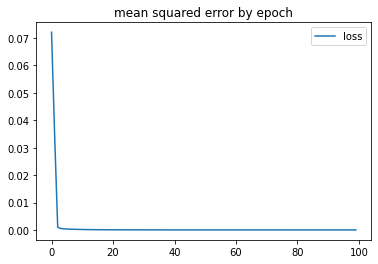

In [72]:
plt.plot(loss.history['loss'], label='loss')
plt.title('mean squared error by epoch')
plt.legend()
plt.show

In [73]:
predicted = model.predict(xtest)

In [74]:
combined_array = np.concatenate((ytest, predicted), axis = 1)

### Evaluating the Model

In [75]:
import sklearn.metrics as metrics

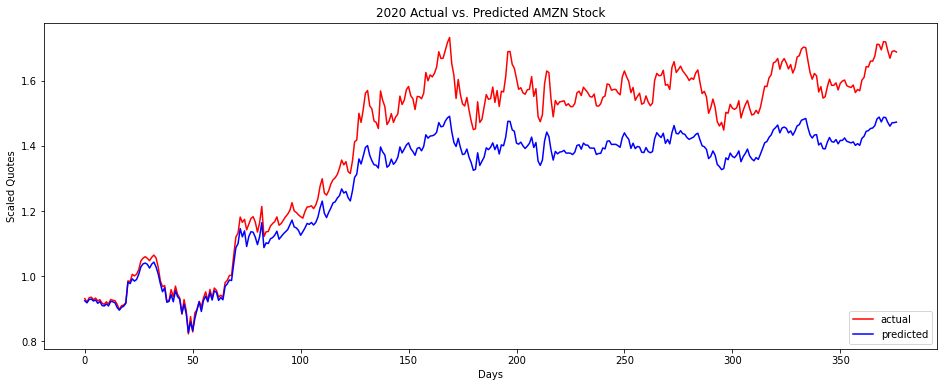

In [76]:
plt.figure(figsize=(16,6))
plt.plot(combined_array[:,0],color='red', label='actual')
plt.plot(combined_array[:,1],color='blue', label='predicted')
plt.legend(loc = 'lower right')
plt.title('2020 Actual vs. Predicted AMZN Stock')
plt.xlabel('Days')
plt.ylabel('Scaled Quotes')
plt.show()

In [77]:
import sklearn.metrics as metrics
np.sqrt(metrics.mean_squared_error(ytest,predicted))

0.14247155474614592